# Lesson 6: pets revisited

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [4]:
transforms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [5]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [6]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(transforms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [7]:
data = get_data(224, bs, 'zeros')

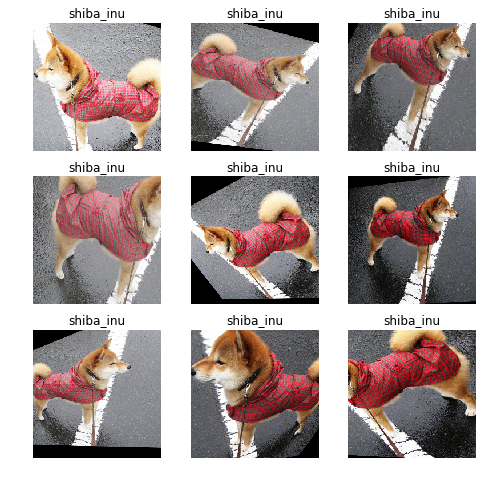

In [8]:
def _plot(i,j,ax):
    x,y = data.train_ds[42]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [9]:
data = get_data(224,bs)

## Train a model

In [34]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [35]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.574018,1.386510,0.296346,01:16
1,1.534311,0.361177,0.085250,01:07
2,0.912427,0.286202,0.077808,01:08


In [36]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.689117,0.297534,0.069012,01:12
1,0.673793,0.280133,0.058863,01:11


In [38]:
data = get_data(352,bs)
learn.data = data

In [39]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.622680,0.281973,0.054804,02:34
1,0.594581,0.275956,0.052774,02:28


In [40]:
learn.save('352')

## Convolution kernel

In [12]:
data = get_data(352,16)

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category shiba_inu

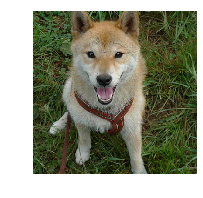

In [20]:
idx=90
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [23]:
k = tensor([
    [0., -5/3, 1],
    [-5/3, -5/3, 1],
    [1., 1 ,1.],
]).expand(1,3,3,3)/6

In [30]:
t = data.valid_ds[idx][0].data; t.shape

torch.Size([3, 352, 352])

In [32]:
edge = F.conv2d(t[None], k)

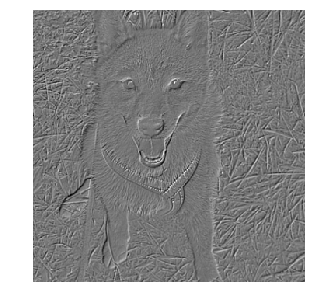

In [33]:
show_image(edge[0], figsize=(5,5));

## Heatmap

In [35]:
m = learn.model.eval();

In [36]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [37]:
from fastai.callbacks.hooks import *

In [38]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [44]:
hook_a,hook_g = hooked_backward()

In [40]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [41]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [66]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='viridis');

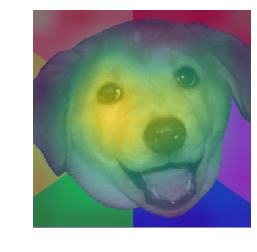

In [67]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [45]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [46]:
mult = (acts*grad_chan[...,None,None]).mean(0)

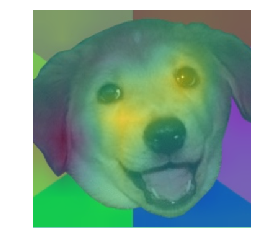

In [68]:
show_heatmap(mult)

In [58]:
fn = path/'../other/advicedog.jpg' #Replace with your own image

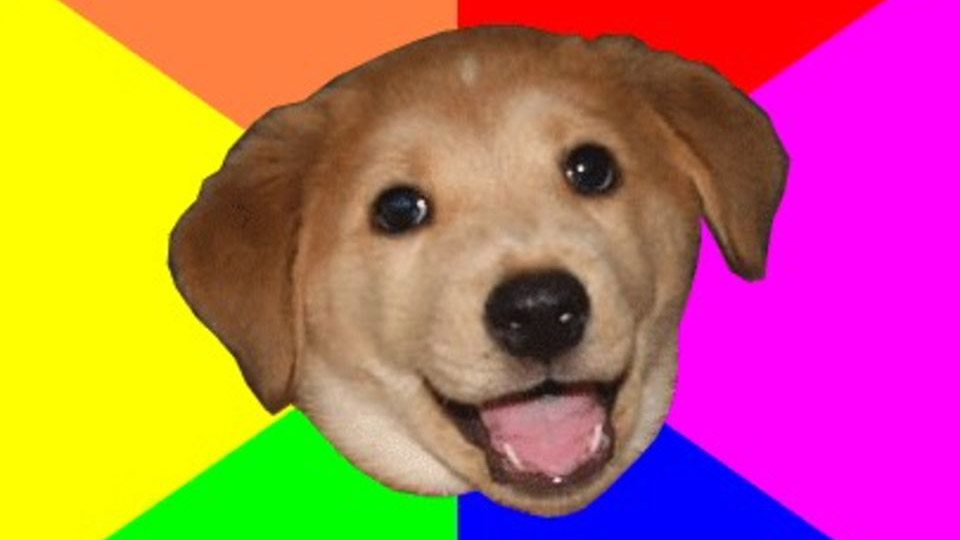

In [59]:
x = open_image(fn); x

In [60]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [61]:
hook_a,hook_g = hooked_backward()

In [62]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

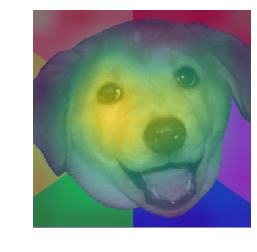

In [69]:
show_heatmap(avg_acts)

In [64]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

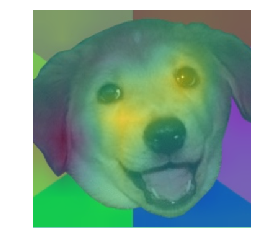

In [70]:
show_heatmap(mult)

# Inside the Convolution Neural Network

In [7]:
transforms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [8]:
path = untar_data(URLs.PETS)/'images'

In [9]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [10]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(transforms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [11]:
data = get_data(352,16)

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category shiba_inu

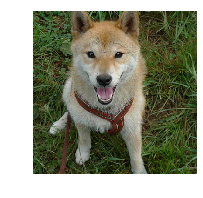

In [13]:
idx=90
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [14]:
m = learn.model.eval();

In [15]:
fn = path/'../other/doge.jpg' 

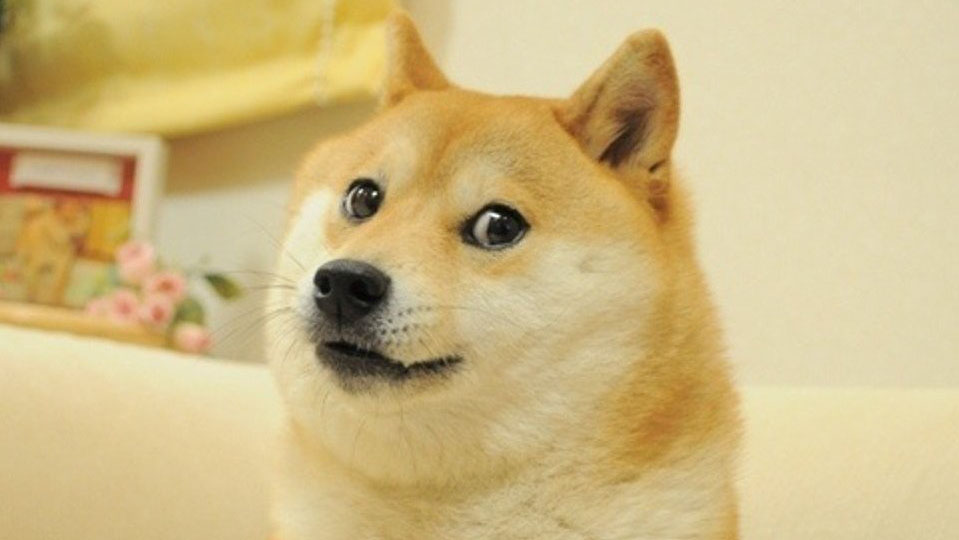

In [16]:
x = open_image(fn); x

In [17]:
from fastai.callbacks.hooks import *

In [18]:
def hookedLayers():
    with hook_output(m[0][0]) as hookedA:
        preds = m(xb)
        with hook_output(m[0][5][0].conv1) as hookedB:
            preds = m(xb)
            with hook_output(m[0][6][0].conv1) as hookedC:
                preds = m(xb)
        
    return hookedA, hookedB, hookedC

In [19]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [20]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [38]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

In [21]:
hookedA, hookedB, hookedC = hookedLayers()

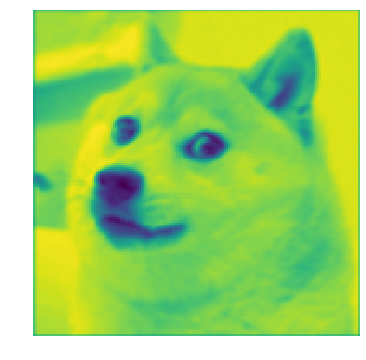

In [32]:
Image(hookedA.stored[0][63:64]).show(figsize=(6,6))

In [33]:
def createForPlot(convolutionLayer):
    def _plotConvolutionalLayer(i,j,ax):
        rando = random.randint(1,convolutionLayer.shape[0] - 1)
        x =Image(convolutionLayer[rando:1+rando])
        x.show(ax)
    return _plotConvolutionalLayer

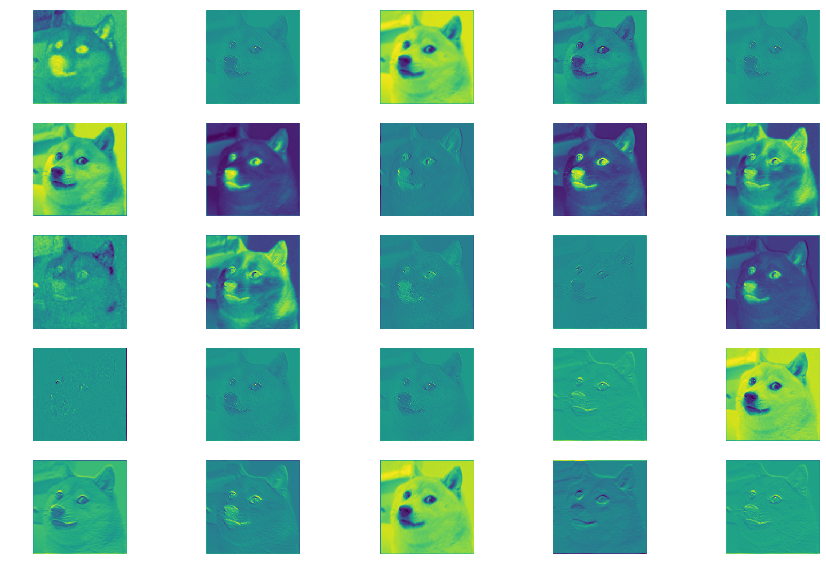

In [35]:
plot_multi(createForPlot(hookedA.stored[0]), 5, 5, figsize=(15,10))

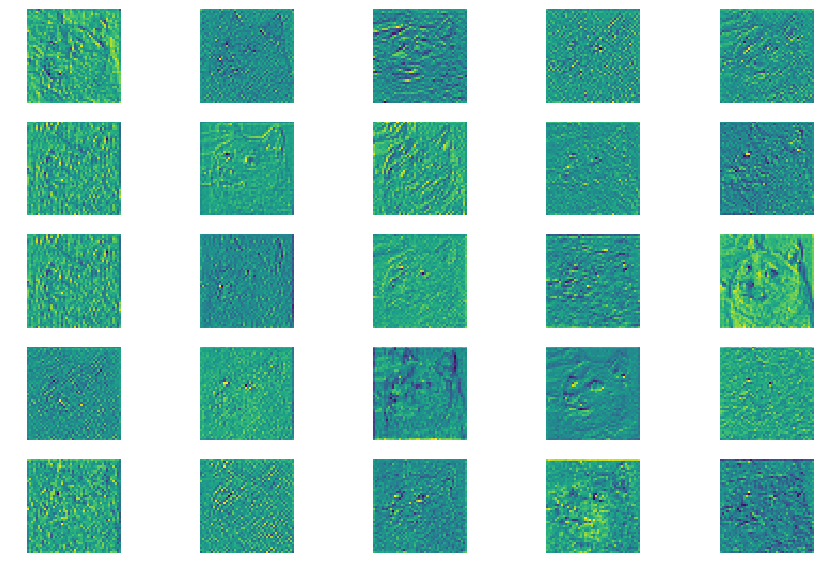

In [36]:
plot_multi(createForPlot(hookedB.stored[0]), 5, 5, figsize=(15,10))

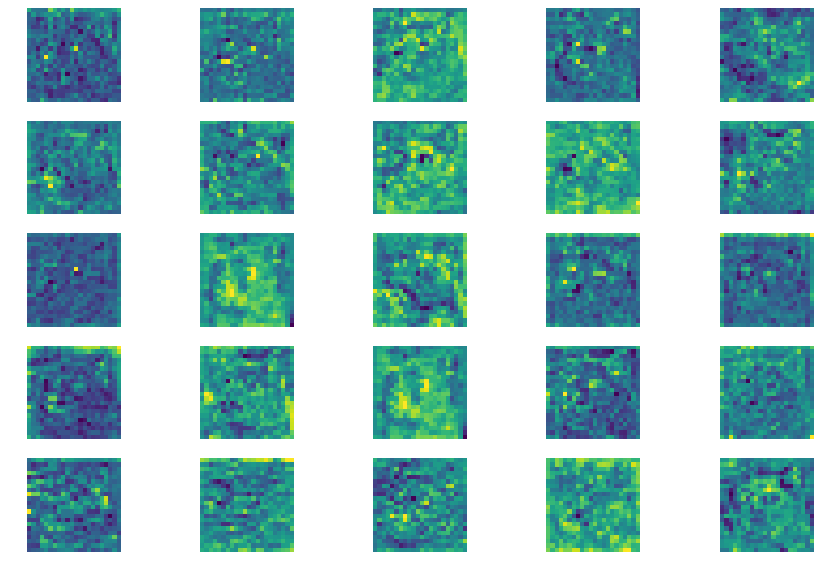

In [37]:
plot_multi(createForPlot(hookedC.stored[0]), 5, 5, figsize=(15,10))

## fin